## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-03-31 12:47:12.885 | INFO     |  Running on cpu


In [3]:
#task = 'TurnOnLight'
task = 'PressButton'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-03-31 12:47:15.710 | INFO     |  Loading dataset(s): 
2025-03-31 12:47:15.711 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/PressButton/demos/metadata.json
2025-03-31 12:47:15.712 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-03-31 12:47:15.712 | INFO     |    Extracted tsdf object labels []
2025-03-31 12:47:15.713 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=tor

In [4]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([99, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([99]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([99, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([99, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([99, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([99, 3, 256, 256]), device=cpu, dtype=to

In [ ]:
tag="no_time"

tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False, #Use rotation aswell?

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    trans_cov_mask_t_pos_corr = False,

    em_steps=1,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=5e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False, #Does prune segmentation

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.01,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=2,
    max_idx_distance=6,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-03-31 12:47:19.357 | INFO     |  Fitting AutoTPGMM
2025-03-31 12:47:19.358 | INFO     |  Performing fitting actions: [INIT]
2025-03-31 12:47:19.358 | INFO     |  Segmenting trajectories


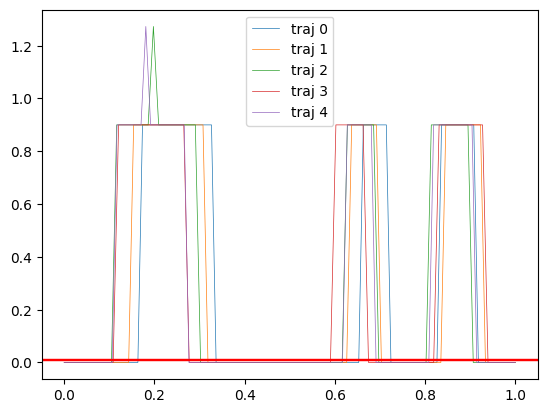

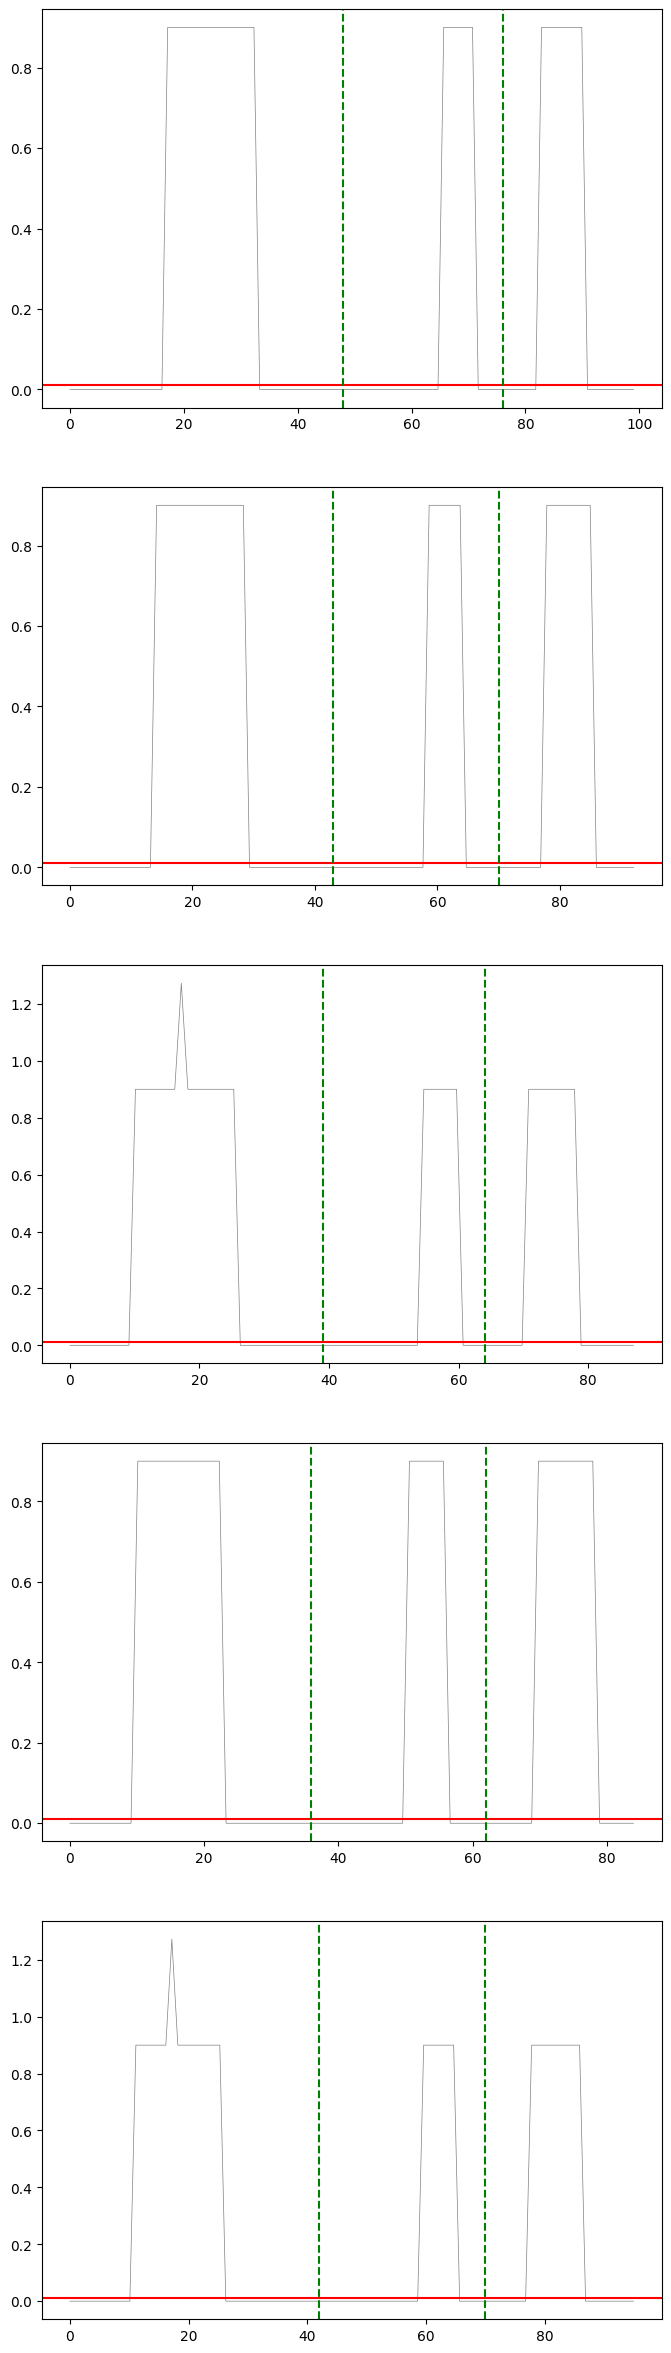

2025-03-31 12:47:20.149 | INFO     |  Creating segement of demos.
2025-03-31 12:47:20.151 | INFO     |  Subsampling to length 41 using strategy mean-length.
2025-03-31 12:47:20.152 | INFO     |  Creating segement of demos.
2025-03-31 12:47:20.155 | INFO     |  Subsampling to length 26 using strategy mean-length.
2025-03-31 12:47:20.156 | INFO     |  Creating segement of demos.
2025-03-31 12:47:20.158 | INFO     |  Subsampling to length 23 using strategy mean-length.
2025-03-31 12:47:20.162 | INFO     |  ... created 3 segments
2025-03-31 12:47:20.162 | INFO     |    Fitting candidate frame 1/10


ValueError: Should add time or action dimension. What else do you want to predict?

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


In [ ]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [ ]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


In [ ]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

In [ ]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [ ]:
atpgmm.plot_hmm_transition_matrix()

In [ ]:
atpgmm.to_disk(data_root / task / f'demos_gmm_policy-{tag}.pt')

In [ ]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


In [ ]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=False,
    equal_aspect=True,
    per_segment=False,
)